# 0. Importando Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import genextreme
from scipy.stats import gaussian_kde

# 1. Carregar dados

In [2]:
# Se necessário ajuste o diretório onde estão presentes os dados
DATA_DIR = Path("dados/data/")
tte = pd.read_csv(DATA_DIR / "train_tte.csv")
readouts = pd.read_csv(DATA_DIR / "train_operational_readouts.csv")

#print(tte.head())
#print(readouts.head())

# 2. Distribuição do tempo de estudo

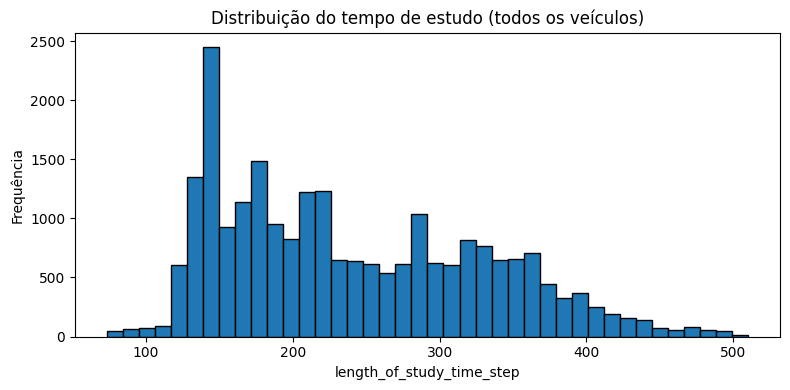

In [3]:
plt.figure(figsize=(8, 4))
plt.hist(tte["length_of_study_time_step"], bins=40, edgecolor="black")
plt.xlabel("length_of_study_time_step")
plt.ylabel("Frequência")
plt.title("Distribuição do tempo de estudo (todos os veículos)")
plt.tight_layout()
plt.savefig("imagens/distribuicao_tempo_estudo.png", dpi=300)
plt.show()

# 3. Proporção de falha x censura

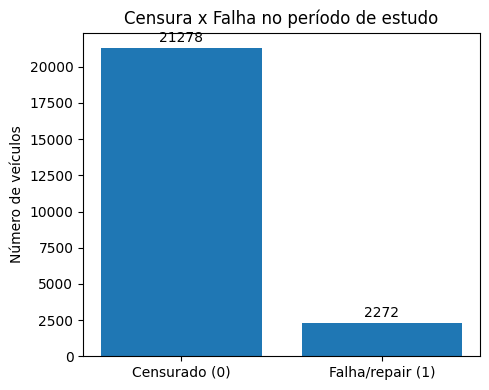

In [4]:
counts = tte["in_study_repair"].value_counts().sort_index()
labels = ["Censurado (0)", "Falha/repair (1)"]

plt.figure(figsize=(5, 4))
plt.bar(labels, counts.values)
for i, v in enumerate(counts.values):
    plt.text(i, v + 0.01 * counts.values.max(), str(v), ha="center", va="bottom")
plt.ylabel("Número de veículos")
plt.title("Censura x Falha no período de estudo")
plt.tight_layout()
plt.savefig("imagens/censura_falha_no_periodo_estudo.png", dpi=300)
plt.show()

# 4. "Curva de sobrevivência" usando GEV para os mínimos de TTF

Número de falhas observadas: 2272
Parâmetros GEV ajustados (para Y = -TTF):
  shape (ξ)  = 0.5247
  loc   (µ)  = -232.6477
  scale (σ)  = 87.4401


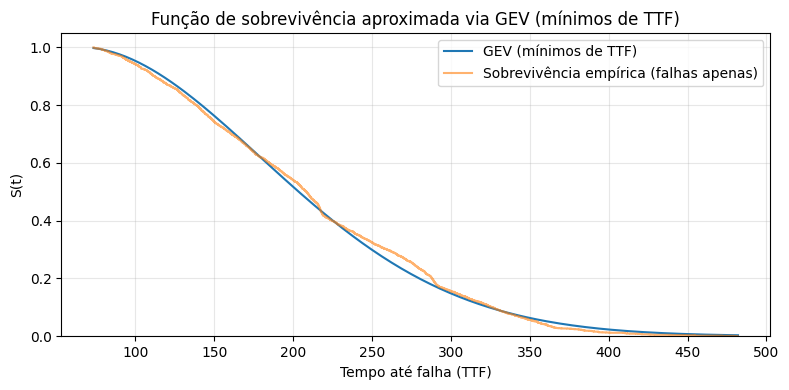

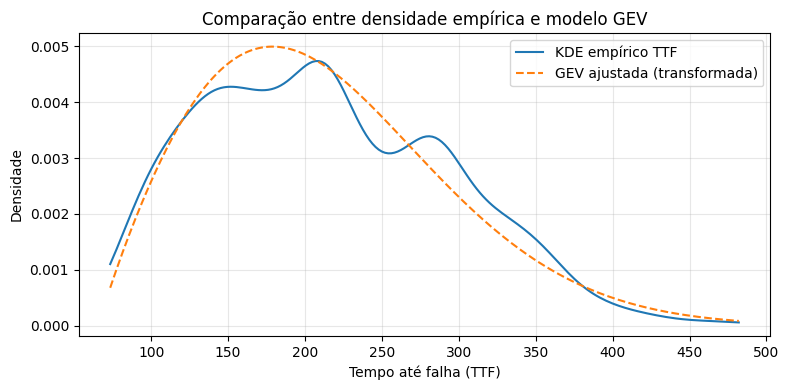

In [5]:
# Apenas os veículos que FALHARAM (evento observado)
time = tte["length_of_study_time_step"].to_numpy().astype(float)
event = tte["in_study_repair"].to_numpy().astype(int)

times_fail = time[event == 1]

print(f"Número de falhas observadas: {len(times_fail)}")

# --- Passo 1: transformar para máximos (Y = -T) ---
y = -times_fail  # agora estamos modelando o máximo de Y

# --- Passo 2: ajustar GEV aos dados de Y ---
# genextreme em SciPy usa o parâmetro "c" para a forma (equivalente ao ξ)
c_hat, loc_hat, scale_hat = genextreme.fit(y)

print("Parâmetros GEV ajustados (para Y = -TTF):")
print(f"  shape (ξ)  = {c_hat:.4f}")
print(f"  loc   (µ)  = {loc_hat:.4f}")
print(f"  scale (σ)  = {scale_hat:.4f}")

# --- Passo 3: construir a função de sobrevivência S_T(t) = G_Y(-t) ---
t_grid = np.linspace(times_fail.min(), times_fail.max(), 200)
y_grid = -t_grid

# CDF da GEV ajustada em Y
G_y = genextreme.cdf(y_grid, c_hat, loc=loc_hat, scale=scale_hat)

# Sobrevivência de T: S_T(t) = P(T > t) = G_Y(-t)
S_gev = G_y

# --- Passo 4: curva empírica simples para comparar (sem censura) ---
# sobrevivência empírica = 1 - ECDF(t)
t_sorted = np.sort(times_fail)
ecdf = np.arange(1, len(t_sorted) + 1) / len(t_sorted)
S_emp = 1 - ecdf  # sobrevivência empírica simples (sem censura)

# --- Passo 5: plots ---
plt.figure(figsize=(8, 4))
plt.plot(t_grid, S_gev, label="GEV (mínimos de TTF)")
plt.step(t_sorted, S_emp, where="post", alpha=0.6,
         label="Sobrevivência empírica (falhas apenas)")
plt.xlabel("Tempo até falha (TTF)")
plt.ylabel("S(t)")
plt.title("Função de sobrevivência aproximada via GEV (mínimos de TTF)")
plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("imagens/funcao_de_sobrevivencia_aproximada_via_gev.png", dpi=300)
plt.show()

# --- Plot da densidade de TTF ajustada pela GEV ---

plt.figure(figsize=(8, 4))

# densidade empírica (KDE) dos tempos até falha
kde = gaussian_kde(times_fail)
t_dense = np.linspace(times_fail.min(), times_fail.max(), 200)
plt.plot(t_dense, kde(t_dense), label="KDE empírico TTF")

# densidade teórica induzida (f_T(t)) a partir do modelo GEV de Y = -T
# f_Y(y) da GEV -> f_T(t) = f_Y(-t)
f_y = genextreme.pdf(-t_dense, c_hat, loc=loc_hat, scale=scale_hat)
plt.plot(t_dense, f_y, linestyle="--", label="GEV ajustada (transformada)")

plt.xlabel("Tempo até falha (TTF)")
plt.ylabel("Densidade")
plt.title("Comparação entre densidade empírica e modelo GEV")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("imagens/comparacao_entre_densidade_empirica_modelo_gev.png", dpi=300)

# 5. Bootstrap do MTTF + histograma

MTTF condicional (falhou): 214.01
IC 95%: [210.71, 217.35]


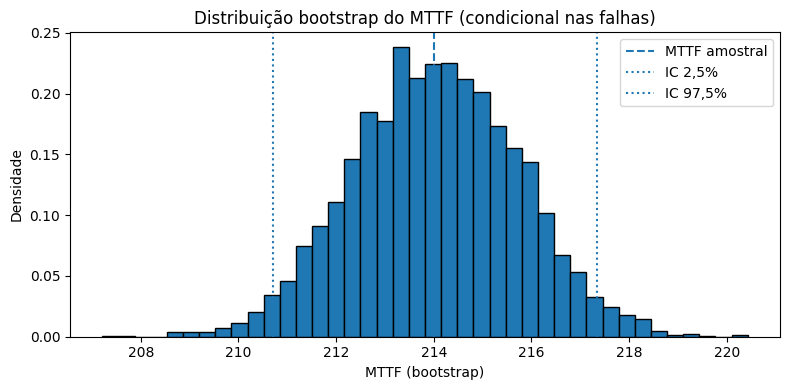

In [6]:
rng = np.random.default_rng(42)

def bootstrap_mttf(tte_df, B=5000):
    time = tte_df["length_of_study_time_step"].to_numpy().astype(float)
    event = tte_df["in_study_repair"].to_numpy().astype(int)

    # vamos usar apenas quem falhou para um MTTF "condicional"
    times_fail = time[event == 1]
    n = len(times_fail)
    mttf_boot = np.empty(B, dtype=float)
    for b in range(B):
        idx = rng.integers(0, n, size=n)
        mttf_boot[b] = times_fail[idx].mean()
    point = times_fail.mean()
    lo, hi = np.percentile(mttf_boot, [2.5, 97.5])
    return point, (lo, hi), mttf_boot

mttf_hat, (mttf_lo, mttf_hi), mttf_boot = bootstrap_mttf(tte)

print(f"MTTF condicional (falhou): {mttf_hat:.2f}")
print(f"IC 95%: [{mttf_lo:.2f}, {mttf_hi:.2f}]")

plt.figure(figsize=(8, 4))
plt.hist(mttf_boot, bins=40, edgecolor="black", density=True)
plt.axvline(mttf_hat, linestyle="--", label="MTTF amostral")
plt.axvline(mttf_lo, linestyle=":", label="IC 2,5%")
plt.axvline(mttf_hi, linestyle=":", label="IC 97,5%")
plt.xlabel("MTTF (bootstrap)")
plt.ylabel("Densidade")
plt.title("Distribuição bootstrap do MTTF (condicional nas falhas)")
plt.legend()
plt.tight_layout()
plt.savefig("imagens/distribuicao_bootstrap_mttf).png", dpi=300)
plt.show()

# 6. Boxplot de um contador operacional por status de falha

/tmp/ipykernel_94428/2353483877.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["Censurado (0)", "Falha (1)"])


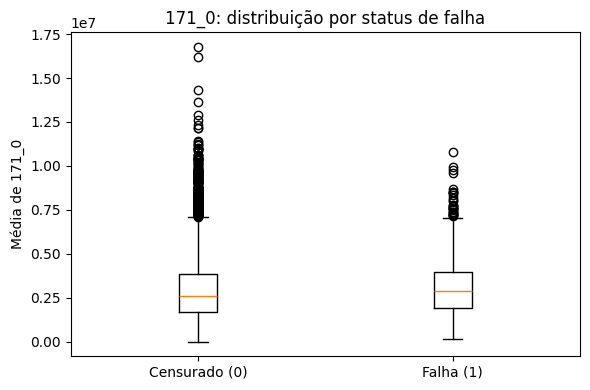

/tmp/ipykernel_94428/2353483877.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["Censurado (0)", "Falha (1)"])


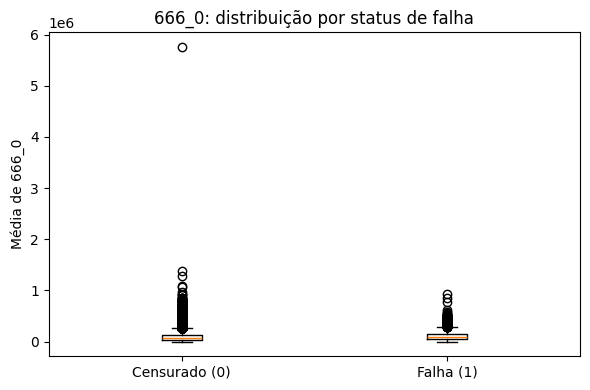

/tmp/ipykernel_94428/2353483877.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["Censurado (0)", "Falha (1)"])


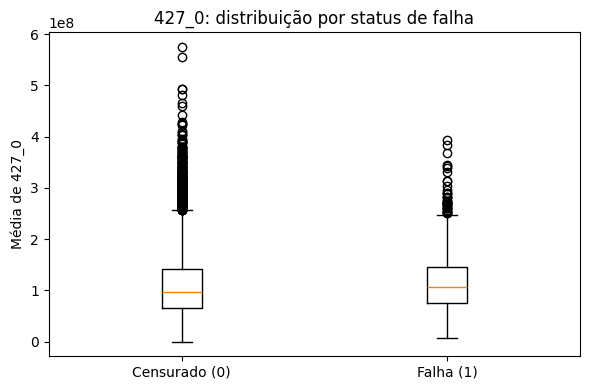

/tmp/ipykernel_94428/2353483877.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["Censurado (0)", "Falha (1)"])


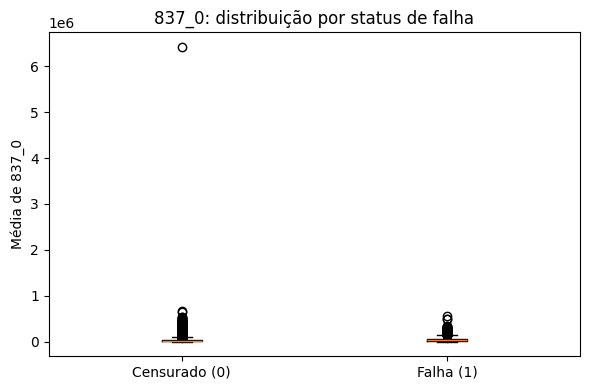

/tmp/ipykernel_94428/2353483877.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["Censurado (0)", "Falha (1)"])


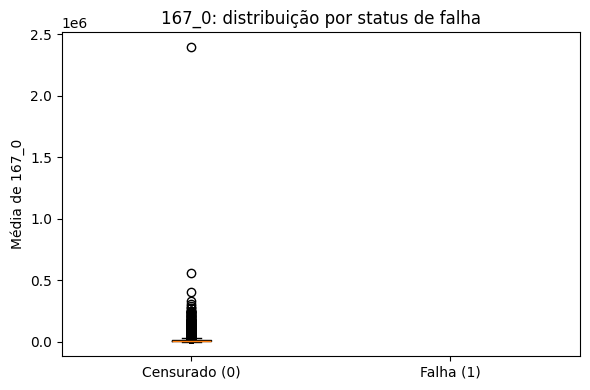

In [7]:
# Pegar os 5 primeiros sensores contadores como exemplo
sensors = readouts.columns[2:7].tolist() # As duas primeiras colunas são 'vehicle_id', 'time_step'

for sensor_col in sensors:
    
    # calcular média do sensor por veículo
    mean_sensor = (
        readouts.groupby("vehicle_id")[sensor_col]
        .mean()
        .rename("mean_sensor")
        .reset_index()
    )
    
    # juntar com tte
    df_join = tte.merge(mean_sensor, on="vehicle_id", how="inner")
    
    plt.figure(figsize=(6, 4))
    data0 = df_join.loc[df_join["in_study_repair"] == 0, "mean_sensor"]
    data1 = df_join.loc[df_join["in_study_repair"] == 1, "mean_sensor"]
    plt.boxplot([data0, data1], labels=["Censurado (0)", "Falha (1)"])
    plt.ylabel(f"Média de {sensor_col}")
    plt.title(f"{sensor_col}: distribuição por status de falha")
    plt.tight_layout()
    plt.savefig(f"imagens/{sensor_col}_distribuicao_por_status_de_falha.png", dpi=300)
    plt.show()

# 7. Evolução temporal dos 5 veículo com mais leitura de dados (exemplo de série)

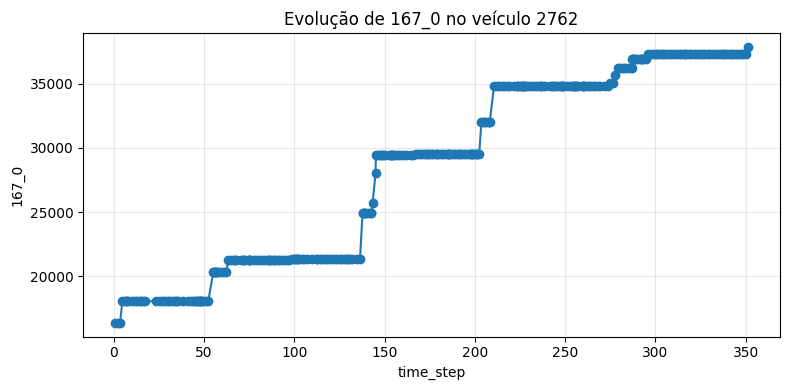

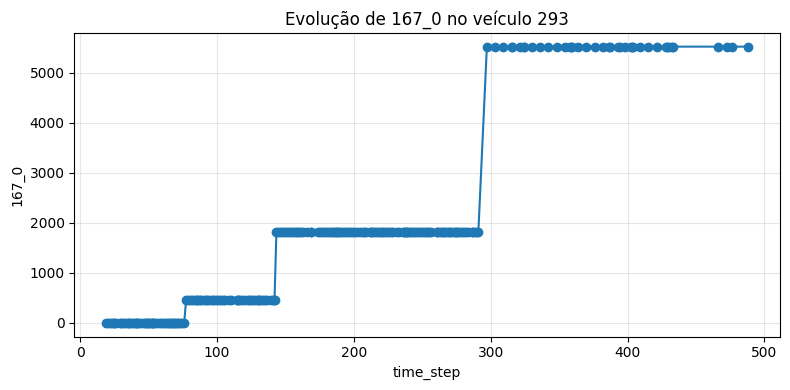

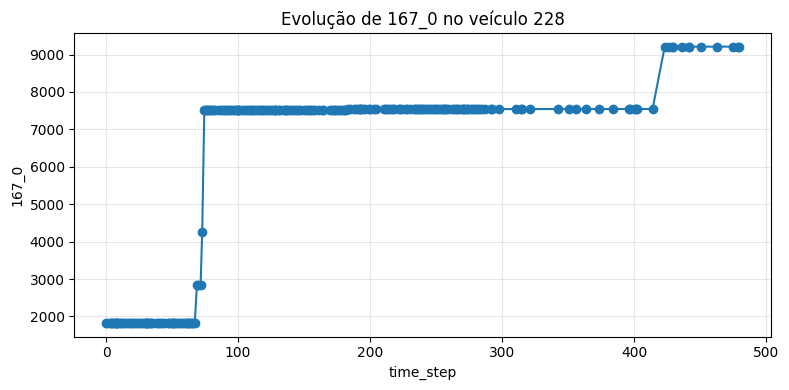

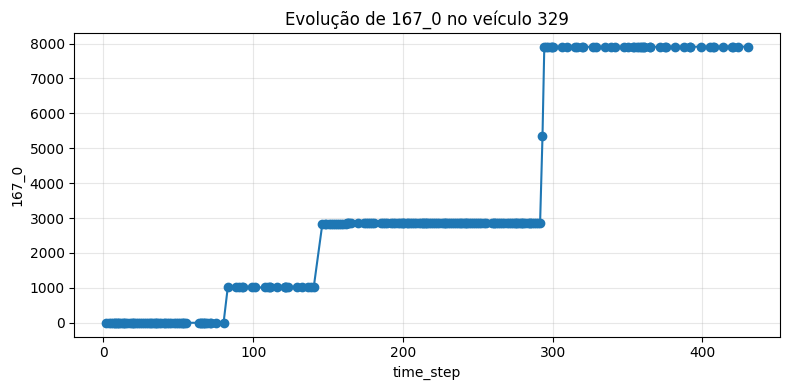

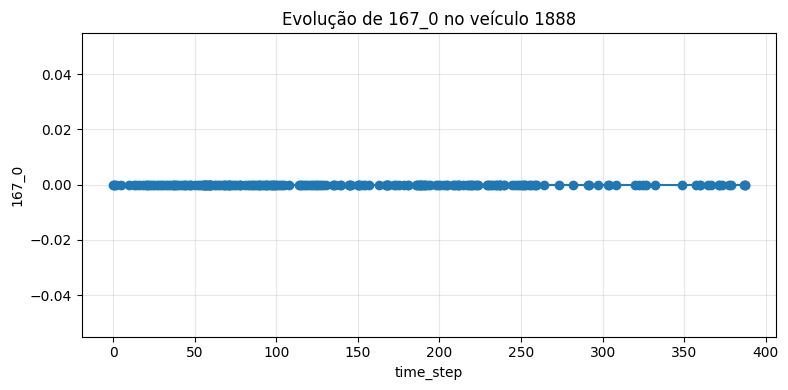

In [8]:
# pega os 5 primeiros veículos que tenham bastante leitura

counts_by_vehicle = readouts["vehicle_id"].value_counts()
veh_examples = counts_by_vehicle.index[0:5]
for veh_example in veh_examples:

    df_veh = readouts[readouts["vehicle_id"] == veh_example].sort_values("time_step")
    
    plt.figure(figsize=(8, 4))
    plt.plot(df_veh["time_step"], df_veh[sensor_col], marker="o")
    plt.xlabel("time_step")
    plt.ylabel(sensor_col)
    plt.title(f"Evolução de {sensor_col} no veículo {veh_example}")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    #plt.savefig(f"imagens/evolucao_de_{sensor_col}_no_veiculo_{veh_example}.png", dpi=300)
    plt.show()